In [37]:
# Install necessary packages
!pip install optuna

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import optuna
import warnings
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor

warnings.filterwarnings("ignore")

# ---------------------------
# Load and preprocess dataset

# ---------------------------
df = pd.read_csv("/content/dataset.csv", low_memory=False)

# Drop unnecessary columns but keep 'artists' for encoding
df.drop(columns=['Unnamed: 0', 'track_id', 'album_name', 'track_name'], inplace=True)

# Encode categorical variable: track_genre
df['track_genre'] = LabelEncoder().fit_transform(df['track_genre'])

# Convert explicit to integer (if it's boolean or string type)
df['explicit'] = df['explicit'].astype(int)

# Handle missing values and duplicates
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)

# ---------------------------
# Feature Engineering
# ---------------------------
# Create new features
df['danceability_energy'] = df['danceability'] * df['energy']
df['acousticness_instrumentalness'] = df['acousticness'] * df['instrumentalness']

# Apply log transformations to reduce skewness
df['log_loudness'] = np.log1p(df['loudness'])
df['log_duration'] = np.log1p(df['duration_ms'])

# Drop original columns replaced by engineered features
df.drop(columns=['loudness', 'duration_ms', 'tempo', 'time_signature', 'liveness'], inplace=True)

# ---------------------------
# Target Encoding for 'artists'
# ---------------------------
# def target_encode(series, target, min_samples_leaf=1, smoothing=1):
#     """Compute target encoding for a categorical variable."""
#     global_mean = target.mean()
#     agg = series.groupby(series).agg(['count', 'mean'])
#     counts = agg['count']
#     means = agg['mean']
#     # Compute smoothing
#     smooth = (counts * means + smoothing * global_mean) / (counts + smoothing)
#     return series.map(smooth).fillna(global_mean)

# Create a new column for target-encoded artists using KFold to mitigate overfitting
kf = KFold(n_splits=5, shuffle=True, random_state=42)
artists_encoded = pd.Series(np.nan, index=df.index)

for train_idx, val_idx in kf.split(df):
    # Use the training fold to compute the mapping
    train_fold = df.iloc[train_idx]
    mapping = train_fold.groupby('artists')['popularity'].mean()
    # Map the validation fold using the computed mapping
    artists_encoded.iloc[val_idx] = df.iloc[val_idx]['artists'].map(mapping)

# In case there are any missing values after mapping, fill them with the global mean
global_pop_mean = df['popularity'].mean()
# df['artists_encoded'] = artists_encoded.fillna(global_pop_mean)

# Optionally, drop the original 'artists' column if you only want to use the encoded value
df.drop(columns=['artists'], inplace=True)

# ---------------------------
# Define features and target variable
# ---------------------------
X = df.drop(columns=['popularity'])
y = df['popularity']

# Normalize features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Split into train & test set
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# ---------------------------
# OPTUNA BAYESIAN OPTIMIZATION FOR XGBOOST
# ---------------------------
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 500, 1500),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0.0, 5.0),
        'lambda': trial.suggest_float('lambda', 1.0, 5.0)
    }

    model = XGBRegressor(**params, objective='reg:squarederror', tree_method='hist', random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return mean_squared_error(y_test, y_pred)

# Run Bayesian Optimization
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)

# Get the best parameters
best_params = study.best_params
print("🔹 Best Hyperparameters for XGBoost:", best_params)

# Train the best XGBoost model
best_xgb = XGBRegressor(**best_params, objective='reg:squarederror', tree_method='hist', random_state=42)
best_xgb.fit(X_train, y_train)
y_pred_xgb = best_xgb.predict(X_test)

# Evaluate XGBoost Model
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)
print(f"🚀 Optimized XGBoost - MSE: {mse_xgb:.2f}, R² Score: {r2_xgb:.2f}")

# ---------------------------
# FEATURE SELECTION USING XGBOOST IMPORTANCE
# ---------------------------
importances = best_xgb.feature_importances_
feature_names = X.columns

# Keep only important features (threshold chosen based on experimentation, e.g., 0.065)
important_features = feature_names[importances > 0.065]
print("🔹 Important Features:", list(important_features))

# Reduce dataset to only selected features
X_train_imp = X_train[:, importances > 0.065]
X_test_imp = X_test[:, importances > 0.065]

# ---------------------------
# TRAINING OTHER MODELS FOR COMPARISON
# ---------------------------
# LightGBM Model
lgb_model = lgb.LGBMRegressor(n_estimators=200, max_depth=10, random_state=42)
lgb_model.fit(X_train_imp, y_train)
y_pred_lgb = lgb_model.predict(X_test_imp)
mse_lgb = mean_squared_error(y_test, y_pred_lgb)
r2_lgb = r2_score(y_test, y_pred_lgb)
print(f"💡 LightGBM - MSE: {mse_lgb:.2f}, R² Score: {r2_lgb:.2f}")

# RandomForest Model
rf = RandomForestRegressor(n_estimators=200, max_depth=10, random_state=42, n_jobs=-1)
rf.fit(X_train_imp, y_train)
y_pred_rf = rf.predict(X_test_imp)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)
print(f"🌳 RandomForest - MSE: {mse_rf:.2f}, R² Score: {r2_rf:.2f}")


[I 2025-04-04 08:53:40,348] A new study created in memory with name: no-name-da4caaa6-6818-4e78-bf3b-6f0362dd149e
[I 2025-04-04 08:53:50,939] Trial 0 finished with value: 193.4991912841797 and parameters: {'n_estimators': 1063, 'max_depth': 5, 'learning_rate': 0.031025403246123285, 'subsample': 0.955294613195596, 'colsample_bytree': 0.663110332843163, 'gamma': 0.18460532751349956, 'lambda': 4.434477875993091}. Best is trial 0 with value: 193.4991912841797.
[I 2025-04-04 08:54:09,865] Trial 1 finished with value: 185.86221313476562 and parameters: {'n_estimators': 988, 'max_depth': 7, 'learning_rate': 0.020499019837987964, 'subsample': 0.937198757627795, 'colsample_bytree': 0.8048921749448666, 'gamma': 4.439058609437977, 'lambda': 1.0431374402675644}. Best is trial 1 with value: 185.86221313476562.
[I 2025-04-04 08:54:58,790] Trial 2 finished with value: 170.20884704589844 and parameters: {'n_estimators': 851, 'max_depth': 10, 'learning_rate': 0.06928789024063545, 'subsample': 0.6543633

🔹 Best Hyperparameters for XGBoost: {'n_estimators': 1155, 'max_depth': 12, 'learning_rate': 0.05514796466078315, 'subsample': 0.7241579388332618, 'colsample_bytree': 0.7692953686285297, 'gamma': 1.403385336127732, 'lambda': 1.0784654057887195}
🚀 Optimized XGBoost - MSE: 167.64, R² Score: 0.63
🔹 Important Features: ['track_genre', 'artists_encoded']
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002013 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 369
[LightGBM] [Info] Number of data points in the train set: 85533, number of used features: 2
[LightGBM] [Info] Start training from score 35.348018
💡 LightGBM - MSE: 192.89, R² Score: 0.58
🌳 RandomForest - MSE: 203.48, R² Score: 0.55


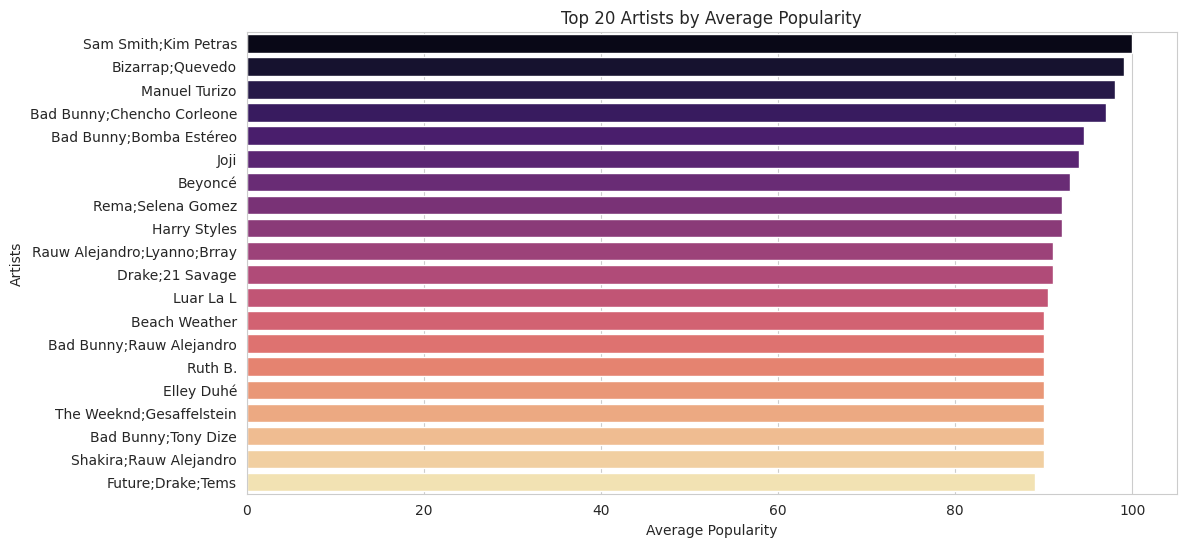

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set_style("whitegrid")
df = pd.read_csv("/content/dataset.csv", low_memory=False)

# ---------------------------
# 🔹 Identify Top Artists by Popularity
# ---------------------------

top_artists = df.groupby('artists')['popularity'].mean().sort_values(ascending=False).head(20)
plt.figure(figsize=(12,6))
sns.barplot(x=top_artists.values, y=top_artists.index, palette='magma')
plt.xlabel("Average Popularity")
plt.ylabel("Artists")
plt.title("Top 20 Artists by Average Popularity")
plt.show()





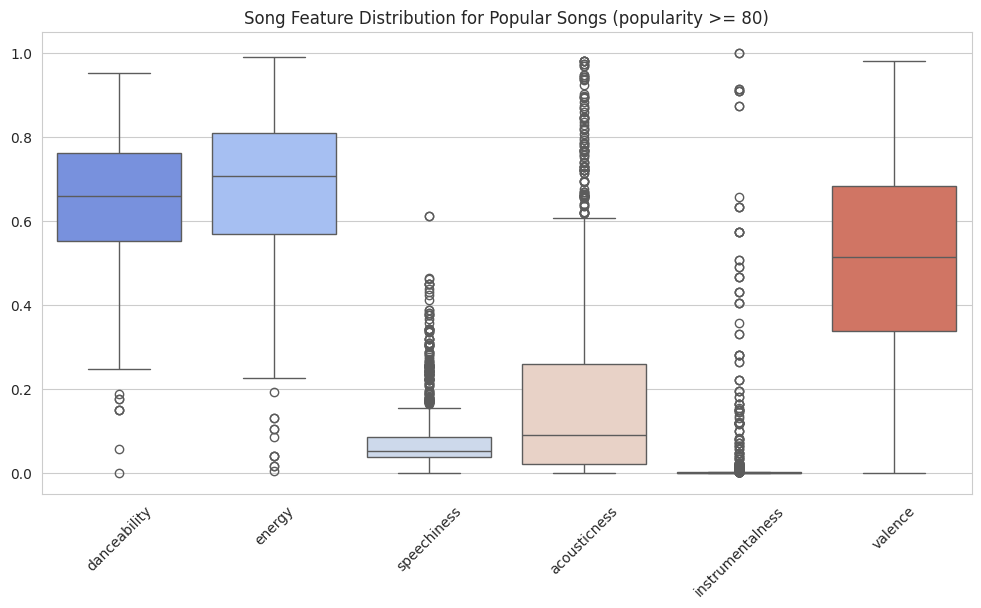

In [21]:
# ---------------------------
# 🔹 Analyze Song Characteristics of Popular Songs
# ---------------------------

df_high_pop = df[df['popularity'] >= 80]  # Consider songs with popularity >= 80

features = ['danceability', 'energy', 'speechiness', 'acousticness', 'instrumentalness', 'valence']
plt.figure(figsize=(12,6))
sns.boxplot(data=df_high_pop[features], palette="coolwarm")
plt.title("Song Feature Distribution for Popular Songs (popularity >= 80)")
plt.xticks(rotation=45)
plt.show()

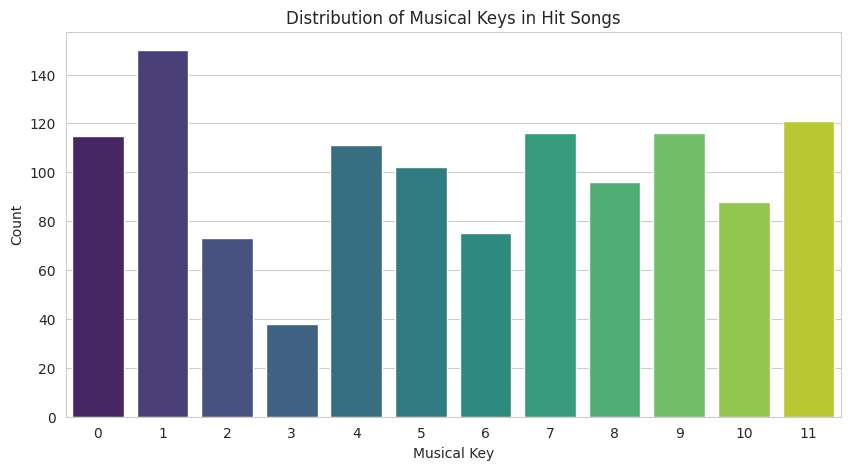

In [22]:
# ---------------------------
#  Key and Mode Patterns of Hit Songs
# ---------------------------

df_hit_songs = df[df['popularity'] >= 80]

# Key Distribution
plt.figure(figsize=(10,5))
sns.countplot(x=df_hit_songs['key'], palette='viridis')
plt.xlabel("Musical Key")
plt.ylabel("Count")
plt.title("Distribution of Musical Keys in Hit Songs")
plt.show()



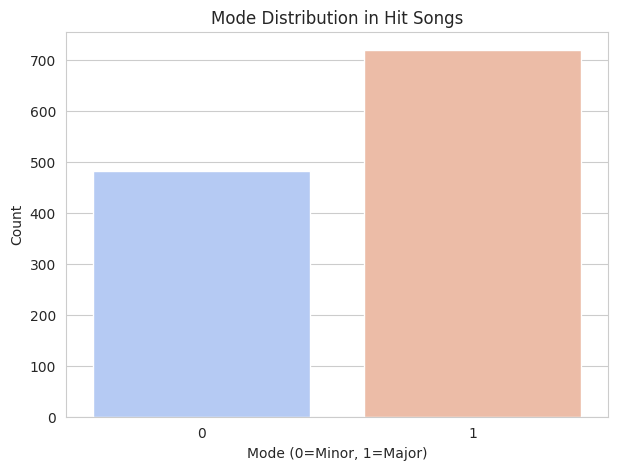

In [23]:
# Mode Distribution
plt.figure(figsize=(7,5))
sns.countplot(x=df_hit_songs['mode'], palette='coolwarm')
plt.xlabel("Mode (0=Minor, 1=Major)")
plt.ylabel("Count")
plt.title("Mode Distribution in Hit Songs")
plt.show()


In [38]:
import joblib

# Save LabelEncoder for track_genre
label_encoder = LabelEncoder().fit(df['track_genre'])
joblib.dump(label_encoder, 'label_encoder.pkl')

# Save MinMaxScaler
joblib.dump(scaler, 'scaler.pkl')

# Save important features list
joblib.dump(important_features, 'important_features.pkl')

# Save trained XGBoost model
joblib.dump(best_xgb, 'popularity_predictor.pkl')

['popularity_predictor.pkl']

In [29]:
df['artists'].unique()

array(['Gen Hoshino', 'Ben Woodward', 'Ingrid Michaelson;ZAYN', ...,
       'Cuencos Tibetanos Sonidos Relajantes',
       'Bryan & Katie Torwalt;Brock Human', 'Jesus Culture'], dtype=object)

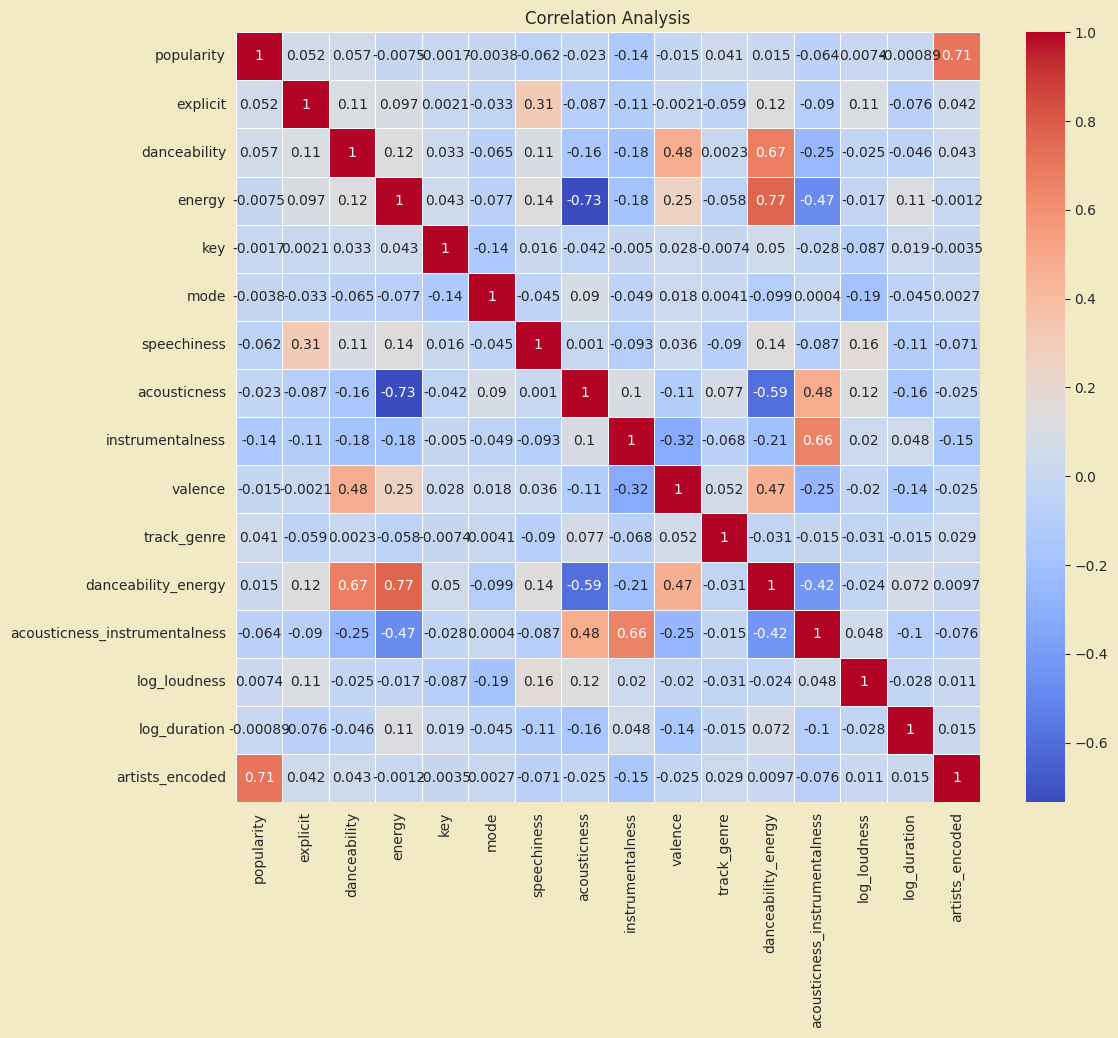

In [39]:
# Including numerical colmumns
corr_mat = df.select_dtypes(include=["int", "float"]).corr()

# Adjusting figure visuals
plt.figure(figsize=(12, 10), facecolor='#F2EAC5', edgecolor='black')
ax = plt.axes()
ax.set_facecolor('#F2EAC5')
sns.heatmap(corr_mat, annot=True, cmap='coolwarm', linewidths=0.5, annot_kws={"size": 10})
plt.title('Correlation Analysis')
plt.show()